In [13]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [5]:
company_code = 'WMT'
Dataset_dir = 'stock_history'
work_type = 'stock_cnn_blog_pub-master'
root_path = Path(os.getcwd())
dataset_path = os.path.join(root_path, work_type, Dataset_dir, company_code, company_code + ".csv")

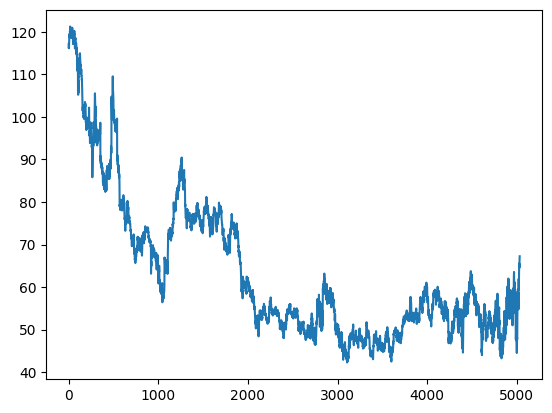

In [6]:
df =pd.read_csv(dataset_path)
df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
df.close.plot()
df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)
data = df

In [7]:
# Initialize the output DataFrame
indicators_df = data.copy()

# Moving Averages (Simple and Exponential)
for window in [5, 10, 20, 50, 100, 200]:
    indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
    indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

# Momentum Indicators
indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                              indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                  (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

# Williams %R
indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                 (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

# Moving Average Convergence Divergence (MACD)
indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

# Average Directional Index (ADX)
high_diff = indicators_df['High'].diff()
low_diff = indicators_df['Low'].diff()
plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
true_range = pd.DataFrame({
    'hl': indicators_df['High'] - indicators_df['Low'],
    'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
    'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
}).max(axis=1)
indicators_df['ATR'] = true_range.rolling(window=14).mean()
indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

# Commodity Channel Index (CCI)
typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

# Bollinger Bands
indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

# Rate of Change (ROC)
indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

# On-Balance Volume (OBV)
obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
               np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
indicators_df['OBV'] = obv.cumsum()

# Force Index
indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

# Accumulation/Distribution Line (ADL)
adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
       (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
indicators_df['ADL'] = adl.cumsum()

# Money Flow Index (MFI)
money_flow = typical_price * indicators_df['Volume']
positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

# Accumulation Swing Index (ASI)
indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                        (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                        (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

# Chaikin Oscillator
indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()


In [8]:
df_processed = indicators_df.dropna().reset_index()

In [9]:
predicted_prices = df_processed.SMA_10.values

In [10]:
def plotting_signal(prices, signal_values):
    # Plot the results
    plt.figure(figsize=(15, 10))
    plt.plot(prices, linewidth=0.6, color='blue', label='Predicted Prices', )
    # plt.plot(df_h4['avg'].values[-length:], color='red', linewidth=0.3, label='Actaul Prices')
    # plt.plot(ema, label='EMA', linestyle='--', color='green', linewidth=0.3)
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 1, prices, np.nan), marker='^', color='g', label='Buy Signal')
    plt.scatter(np.arange(len(prices)), np.where(signal_values == 2, prices, np.nan), marker='v', color='r', label='Sell Signal')

    # Annotate the important points
    # for index, price in important_points:
    #     plt.annotate(f'{price:.5f}', (index, price),
    #                  textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    plt.legend()
    plt.title('Predicted Prices and EMA with Buy/Sell Signals and Important Points')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

def signals_generator(predicted_prices, time_steps, price_diff_new_signal = 0.0030 ):
    # Provided predicted price array
    # predicted_prices = np.array([1.07741435, 1.07797974, 1.07768342, 1.07768771, 1.07819248,
    #                              1.07827098, 1.07808965, 1.07778313, 1.07765595, 1.07710098,
    #                              1.07924897, 1.08013435, 1.0815506, 1.08151388, 1.08143381])

    # Define EMA parameters
    n = time_steps  # Number of periods
    alpha = 2 / (n + 1)

    # Calculate EMA using np.convolve
    ema = np.zeros_like(predicted_prices)
    ema[0] = predicted_prices[0]  # First EMA value is the first price

    for i in range(1, len(predicted_prices)):
        ema[i] = alpha * predicted_prices[i] + (1 - alpha) * ema[i-1]

    # Initialize signals
    signals = np.zeros(len(predicted_prices))

    # Generate signals based on EMA crossover
    for i in range(1, len(predicted_prices)):
        if predicted_prices[i] > ema[i] and predicted_prices[i-1] <= ema[i-1]:
            signals[i] = 1  # Buy signal
        elif predicted_prices[i] < ema[i] and predicted_prices[i-1] >= ema[i-1]:
            signals[i] = 2  # Sell signal
        else:
            signals[i] = 0  # Hold signal
        # Print predicted prices at start, buy/sell signals, and end
        
    start = 0
    end = len(signals) - 1
    important_points = []

    for i in range(len(signals)):
        if i == start or i == end or signals[i] != 0:
            important_points.append((i, predicted_prices[i]))
    
    pip_change_min = price_diff_new_signal        
    # Calculate and print percentage changes
    for j in range(1, len(important_points)):
        index_prev, price_prev = important_points[j - 1]
        index_curr, price_curr = important_points[j]
    #     percent_change = ((price_curr - price_prev) / price_prev) * 100
        pip_change = (price_curr - price_prev)
        if pip_change_min < abs(pip_change):
            # print(f"Change from index {index_prev} to {index_curr}: {pip_change:.4f}")
            pass

        else:
            signals[index_prev] = 0
    #         signals[index_curr] = 0

            
    return signals, np.unique(signals, return_counts=True)

In [11]:
signals, stats = signals_generator(df_processed.SMA_10.values, 30, 3)
stats

(array([0., 1., 2.]), array([4781,   21,   26]))

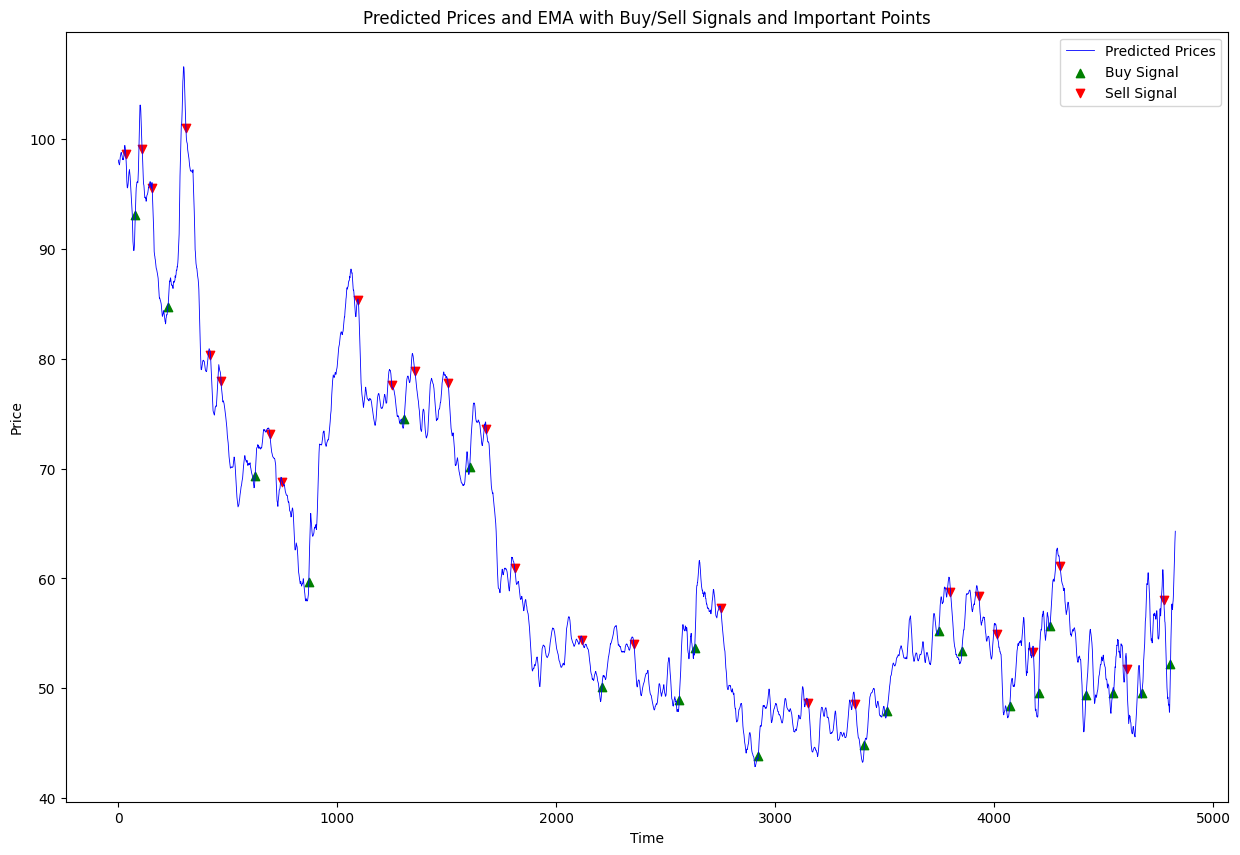

In [14]:
plotting_signal(df_processed.SMA_10.values, signals)

In [28]:
print(df_processed.columns)
len(df_processed.columns)

Index(['Open', 'High', 'Low', 'Close', 'adjusted_close', 'Volume', 'SMA_5',
       'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50',
       'SMA_100', 'EMA_100', 'SMA_200', 'EMA_200', 'RSI_14', 'Stochastic_K',
       'Stochastic_D', 'Williams_%R', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'CCI', 'Bollinger_Mid',
       'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'OBV', 'Force_Index',
       'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator', 'Target'],
      dtype='object')


41

In [16]:
df_processed['Target'] = pd.Series(signals)
df_processed['Target'] = df_processed['Target'].astype(np.int8)
df_processed = df_processed.drop(columns=['index', 'timestamp'])

### Preprocess the Data

In [21]:
df_processed.iloc[:,:-1]

,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,EMA_10,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,98.107,98.316473,...,100.3810,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06
1,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,97.868,98.115296,...,100.0655,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05
2,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,97.831,98.152515,...,99.8050,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06
3,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,97.725,98.155694,...,99.5600,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06
4,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,97.670,98.178295,...,99.3555,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,61.665,62.133219,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
4824,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,62.665,62.678088,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
4825,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,63.258,63.111163,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
4826,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,63.689,63.681861,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [22]:
scaler = MinMaxScaler()
features = scaler.fit_transform(df_processed.iloc[:,:-1])
labels = df_processed['Target'].values

### Create Time-Series Windows

In [23]:
def create_sequences(data, labels, window_size):
    x, y = [], []
    for i in range(len(data) - window_size):
        x.append(data[i:i + window_size])
        y.append(labels[i + window_size])
    return np.array(x), np.array(y)

window_size = 10
x, y = create_sequences(features, labels, window_size)


### Reshape for 2D CNN

In [24]:
# Add a "channel" dimension for Conv2D: (samples, height, width, channels)
x = x.reshape((x.shape[0], x.shape[1], x.shape[2], 1))

# One-hot encode labels
y = to_categorical(y, num_classes=3)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


### Build and Train the 2D CNN Model

In [29]:
# Define the model
model = Sequential()

# First Conv2D layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                 input_shape=(window_size, len(df_processed.columns)-1, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Second Conv2D layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for classification
model.add(Dense(3, activation='softmax'))  # 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 10, 40, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 20, 32)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 20, 32)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 20, 64)         18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 3, 10, 64)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 3, 10, 64)        

In [30]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=50, batch_size=32)

Epoch 1/50
121/121 [==============================] - 1s 5ms/step - loss: 0.0993 - accuracy: 0.9831 - val_loss: 0.0876 - val_accuracy: 0.9876
Epoch 2/50
121/121 [==============================] - 1s 5ms/step - loss: 0.0679 - accuracy: 0.9909 - val_loss: 0.0833 - val_accuracy: 0.9876
Epoch 3/50
121/121 [==============================] - 1s 5ms/step - loss: 0.0660 - accuracy: 0.9909 - val_loss: 0.0823 - val_accuracy: 0.9876
Epoch 4/50
121/121 [==============================] - 1s 5ms/step - loss: 0.0649 - accuracy: 0.9909 - val_loss: 0.0878 - val_accuracy: 0.9876
Epoch 5/50
121/121 [==============================] - 1s 5ms/step - loss: 0.0648 - accuracy: 0.9909 - val_loss: 0.0760 - val_accuracy: 0.9876
Epoch 6/50
121/121 [==============================] - 1s 4ms/step - loss: 0.0679 - accuracy: 0.9909 - val_loss: 0.0754 - val_accuracy: 0.9876
Epoch 7/50
121/121 [==============================] - 1s 4ms/step - loss: 0.0639 - accuracy: 0.9909 - val_loss: 0.0787 - val_accuracy: 0.9876
Epoch 

In [31]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 [==============================] - 0s 2ms/step - loss: 0.0822 - accuracy: 0.9876
Test Accuracy: 0.9876


In [32]:
from sklearn.metrics import classification_report
import numpy as np

# Predictions
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))


31/31 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       952
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         9

    accuracy                           0.99       964
   macro avg       0.33      0.33      0.33       964
weighted avg       0.98      0.99      0.98       964



/home/iftekhar/LLM_CHATGPT_ENV/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iftekhar/LLM_CHATGPT_ENV/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/iftekhar/LLM_CHATGPT_ENV/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


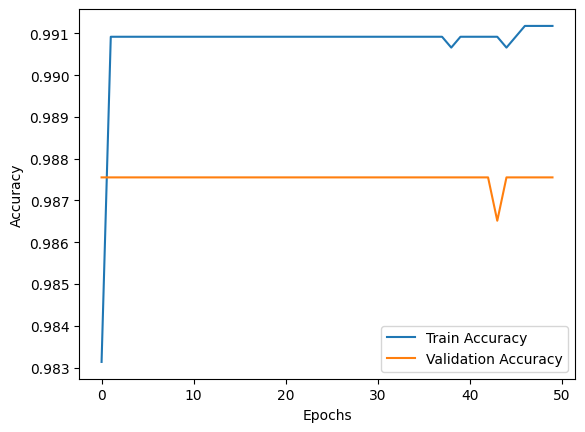

In [33]:
import matplotlib.pyplot as plt

# Plot training accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
